## Dataset overview
- users.csv: Customer information
- orders.csv: Transaction history
- subscriptions.csv: Subscription data
- preferences.csv: Customer taste preferences
- events.scv: User behavioral events (page views, cart actions)
- voucher_application: Voucher usage data
- user_references.csv: Referral tracking
- products.csv: Product catalog

## Key Question
- Understand what are different groups among current customer base. 
- How do they differ? What are their needs? 
- What are the implications for the marketing strategy in terms of attracting similar new customers and/or retaining current customers?
- How can these insights be used to recommend QLab Tea’s next action for user growth?


In [1]:
FILTER_WARNINGS = False

In [2]:
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.DEBUG)

In [3]:
import pandas as pd
import numpy as np
import json
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


sns.set_style("darkgrid")
sns.set_palette("husl")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

if FILTER_WARNINGS:
    import warnings
    warnings.filterwarnings("ignore")

logging.info("Setup completed successfully")
logging.debug("Using ENV variables:")
logging.debug(f"FILTER_WARNINGS: {FILTER_WARNINGS}")
logging.warning("This is a warning message.")
logging.error("This is an error message.")
logging.critical("This is a critical message.")

DEBUG:matplotlib:matplotlib data path: c:\Users\ricky\Desktop\NTU\Tri2\BS6206-Experential_Data_Science\.venv\lib\site-packages\matplotlib\mpl-data
DEBUG:matplotlib:CONFIGDIR=C:\Users\ricky\.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is win32
DEBUG:matplotlib:CACHEDIR=C:\Users\ricky\.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from C:\Users\ricky\.matplotlib\fontlist-v390.json
INFO:root:Setup completed successfully
DEBUG:root:Using ENV variables:
DEBUG:root:FILTER_WARNINGS: False
ERROR:root:This is an error message.
CRITICAL:root:This is a critical message.


In [4]:
logging.debug("Loading datasets")

try:
    users_df = pd.read_csv("./original_data/users.csv")
    orders_df = pd.read_csv("./original_data/orders.csv")
    subscriptions_df = pd.read_csv("./original_data/subscriptions.csv")
    products_df = pd.read_csv("./original_data/products.csv")

    preferences_df = pd.read_csv("./original_data/preferences.csv")
    events_df = pd.read_csv("./original_data/events.csv")
    voucher_applications_df = pd.read_csv("./original_data/voucher_applications.csv")
    user_references_df = pd.read_csv("./original_data/user_references.csv")

    logging.info(f"Users: {len(users_df):,} rows")
    logging.info(f"Orders: {len(orders_df):,} rows")
    logging.info(f"Subscriptions: {len(subscriptions_df):,} rows")
    logging.info(f"Products: {len(products_df):,} rows")
    logging.info(f"Preferences: {len(preferences_df):,} rows")
    logging.info(f"Events: {len(events_df):,} rows")
    logging.info(f"Voucher Application: {len(voucher_applications_df):,} rows")
    logging.info(f"User References: {len(user_references_df):,} rows")
except FileNotFoundError as e:
    logging.error(f"Error csv not found: {e}")
    raise
except Exception as e:
    logging.critical(f"Load csv error: {e}")
    raise

DEBUG:root:Loading datasets
INFO:root:Users: 47,231 rows
INFO:root:Orders: 264,341 rows
INFO:root:Subscriptions: 25,851 rows
INFO:root:Products: 1,519 rows
INFO:root:Preferences: 19,889 rows
INFO:root:Events: 922,570 rows
INFO:root:Voucher Application: 8,690 rows
INFO:root:User References: 764 rows


In [5]:
display(users_df.head())
display(orders_df.head())
display(events_df.head())

,id,email,country,date_signed_up,active
0,1,xxxx@aviabrams.com,Singapore,2022-10-20,No
1,86499,xxxx@gmail.com,Singapore,2022-05-27,No
2,86500,xxxx@gmail.com,Singapore,2022-04-20,No
3,86501,xxxx@yahoo.com.sg,Singapore,2022-05-05,No
4,86502,xxxx@hotmail.com,Singapore,2022-04-25,No


,order_items,shipping_postal_code,shipping_date,discounts,subscription_id,user_id,id,currency,total_incl_tax,total_excl_tax,shipping_incl_tax,shipping_method,shipping_code,status,date_placed
0,"[{""line_price_before_discounts_excl_tax"": ""18....",320119,2016-02-18,[],NaN,90366.0,110003,SGD,18.0,18.0,0.0,singpost,singpost,Shipped,2021-02-16 19:43:20.861911+00:00
1,"[{""line_price_before_discounts_excl_tax"": ""18....",530451,2016-02-22,[],NaN,90158.0,110004,SGD,18.0,18.0,0.0,singpost,singpost,Shipped,2021-01-10 19:05:32.856741+00:00
2,"[{""line_price_before_discounts_excl_tax"": ""18....",270043,2016-02-22,[],NaN,90103.0,110005,SGD,18.0,18.0,0.0,singpost,singpost,Shipped,2021-01-10 19:06:09.319534+00:00
3,"[{""line_price_before_discounts_excl_tax"": ""9.0...",518153,2016-01-05,[],NaN,90170.0,110006,SGD,9.0,9.0,0.0,singpost,singpost,Shipped,2021-01-04 14:07:55.048641+00:00
4,"[{""line_price_before_discounts_excl_tax"": ""9.0...",437603,2016-01-05,[],NaN,90104.0,110007,SGD,9.0,9.0,0.0,singpost,singpost,Shipped,2021-01-04 15:55:19.485123+00:00


,event,user_id,data,timestamp
0,ACTION_VIEW_PRODUCT,133774,{'product': 4948},2022-09-16 01:07:48.082270+00:00
1,ACTION_ADD_ITEM_TO_CART,133774,{'product': 4463},2022-09-16 01:04:45.772563+00:00
2,ACTION_ADD_ITEM_TO_CART,133774,{'product': 4053},2022-09-16 01:04:38.778368+00:00
3,ACTION_REGISTER,133774,{'ip_address': '113.211.210.84'},2022-09-16 01:04:13.643705+00:00
4,ACTION_LOGIN,93406,{'ip_address': '218.212.203.186'},2022-09-15 23:53:29.392495+00:00


## Data Cleaning

In [6]:
missing_values = {
    "Users": users_df.isnull().sum(),
    "Orders": orders_df.isnull().sum(),
    "Subscriptions": subscriptions_df.isnull().sum(),
    "Products": products_df.isnull().sum(),
    "Preferences": preferences_df.isnull().sum(),
    "Events": events_df.isnull().sum(),
    "Voucher Application": voucher_applications_df.isnull().sum(),
    "User References": user_references_df.isnull().sum(),
}

for k, v in missing_values.items():
    logging.debug(f"{k}")
    logging.debug(f"{v}\n")

DEBUG:root:Users
DEBUG:root:id                 0
email              0
country           30
date_signed_up     0
active             0
dtype: int64

DEBUG:root:Orders
DEBUG:root:order_items                  0
shipping_postal_code       362
shipping_date               85
discounts                    0
subscription_id         142937
user_id                     13
id                           0
currency                     0
total_incl_tax               0
total_excl_tax               0
shipping_incl_tax            0
shipping_method              0
shipping_code                0
status                       0
date_placed                  0
dtype: int64

DEBUG:root:Subscriptions
DEBUG:root:user_id                    0
product_id                 0
shipping_postal_code     986
country                  906
interval                   0
brewing_method          5172
status                     0
last_order              3943
next_order                85
shipping_method            0
currency           

In [7]:
users_clean_df = users_df.copy()
del users_df

In [8]:
orders_clean_df = orders_df.copy()
# Only keep completed orders
orders_clean_df = orders_clean_df[orders_clean_df["status"].isin(["Shipped", "Delivered"])]
# Remove <=0 order totals
orders_clean_df = orders_clean_df[orders_clean_df["total_incl_tax"]>0]
# Fix dates
orders_clean_df["date_placed"] = pd.to_datetime(orders_clean_df["date_placed"], errors="coerce")
orders_clean_df = orders_clean_df.dropna(subset=["date_placed", "user_id"])

logging.debug(f"Cleaned orders: {len(orders_clean_df):,} rows")
logging.debug(f"Date range: {orders_clean_df['date_placed'].min()} - {orders_clean_df['date_placed'].max()}")
logging.debug(f"Total revenue: {orders_clean_df['total_incl_tax'].sum():.3f}")

def parse_order_items(order_items_json):
    try:
        items = json.loads(order_items_json)
        num_items = sum(int(item.get("quantity", 1)) for item in items)
        product_ids = [item.get("product_id") for item in items]
        return pd.Series({
            "num_items": num_items,
            "product_ids": product_ids
        })
    except:
        return pd.Series({"num_items": 1, "product_ids": []})
    
order_items_parsed = orders_clean_df['order_items'].apply(parse_order_items)
orders_clean_df = pd.concat([orders_clean_df, order_items_parsed], axis=1)

logging.debug("Order items parsing done")
logging.info(f"Average item per order: {orders_clean_df['num_items'].mean():.2f}")
logging.debug(orders_clean_df["order_items"][0])
del orders_df

DEBUG:root:Cleaned orders: 118,726 rows
DEBUG:root:Date range: 2020-01-01 00:43:38.691695+00:00 - 2023-12-31 23:53:52.134727+00:00
DEBUG:root:Total revenue: 2598320.290
DEBUG:root:Order items parsing done
INFO:root:Average item per order: 1.27
DEBUG:root:[{"line_price_before_discounts_excl_tax": "18.00", "line_price_before_discounts_incl_tax": "18.00", "line_price_excl_tax": "18.00", "line_price_incl_tax": "18.00", "product_id": "3742", "quantity": "1", "title": "Nevernever", "unit_cost_price": "18.00", "unit_price_excl_tax": "18.00", "unit_price_incl_tax": "18.00", "unit_retail_price": "18.00"}]


In [9]:
subscriptions_clean_df = subscriptions_df.copy()
subscriptions_clean_df = subscriptions_clean_df.dropna(subset = ["user_id"])
date_cols = ["last_order", "next_order", "created", "updated"]
for col in date_cols:
    subscriptions_clean_df[col] = pd.to_datetime(subscriptions_clean_df[col], errors="coerce")
del subscriptions_df

C:\Users\ricky\AppData\Local\Temp\ipykernel_27840\3024286474.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  subscriptions_clean_df[col] = pd.to_datetime(subscriptions_clean_df[col], errors="coerce")
C:\Users\ricky\AppData\Local\Temp\ipykernel_27840\3024286474.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  subscriptions_clean_df[col] = pd.to_datetime(subscriptions_clean_df[col], errors="coerce")
C:\Users\ricky\AppData\Local\Temp\ipykernel_27840\3024286474.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  subscriptions_clean_df[col] = pd.to_datetime(subscriptions_

In [10]:
products_clean_df = products_df.copy()
del products_df

In [11]:
preferences_clean_df = preferences_df.copy()
preferences_clean_df = preferences_df.dropna(subset=["user_id"])
del preferences_df

In [12]:
events_clean_df = events_df.copy()
events_clean_df = events_clean_df.dropna(subset = ["user_id", "timestamp"])
events_clean_df["timestamp"] = pd.to_datetime(events_clean_df["timestamp"], errors="coerce")
del events_df

In [13]:
voucher_applications_clean_df = voucher_applications_df.copy()
voucher_applications_clean_df = voucher_applications_clean_df.dropna(subset=["user_id"])
del voucher_applications_df

In [14]:
user_references_clean_df = user_references_df.copy()
del user_references_df

## Feature Engineering

### 7 types of features
1. RFM (Recency, Frequency, Monetary)
2. Behavioral (purchase patterns)
3. Product Category
4. Subscription
5. Engagement (from events)
6. Promotion (voucher usage)
7. Social (referrals)

#### RFM
- recency_days = (reference_date - max(order_date)) for each customer
- frequency_orders = count of orders per customer
- monetary_total = sum of order totals amount per customer
- avg_order_value = monetary_total/frequency_orders

In [15]:
reference_date = orders_clean_df["date_placed"].max()
logging.debug(f"Reference date: {reference_date}")

rfm_features = orders_clean_df.groupby("user_id").agg({
    "date_placed": lambda x: (reference_date - x.max()).days, # Recency
    "id": "count", # Frequency
    "total_incl_tax": "sum" # Monetary
}).reset_index()

rfm_features.columns = ["user_id", "recency_days", "frequency_orders", "monetary_total"]
rfm_features["avg_order_value"] = rfm_features["monetary_total"]/rfm_features["frequency_orders"]

logging.debug(rfm_features.describe())
display(rfm_features.head())

DEBUG:root:Reference date: 2023-12-31 23:53:52.134727+00:00
DEBUG:root:             user_id  recency_days  frequency_orders  monetary_total  \
count   30835.000000  30835.000000      30835.000000    30835.000000   
mean   106159.930242    656.948435          3.850365       84.265292   
std     13669.916182    395.247368          8.495186      181.103834   
min     86499.000000      0.000000          1.000000        1.000000   
25%     94501.500000    381.000000          1.000000       14.000000   
50%    102682.000000    593.000000          1.000000       36.000000   
75%    117771.500000    952.500000          3.000000       81.000000   
max    133813.000000   1460.000000        208.000000     4790.800000   

       avg_order_value  
count     30835.000000  
mean         27.738322  
std          61.759011  
min           0.560000  
25%           9.000000  
50%          14.800000  
75%          36.000000  
max        4655.720000  


,user_id,recency_days,frequency_orders,monetary_total,avg_order_value
0,86499.0,583,1,2.0,2.0
1,86500.0,619,2,16.0,8.0
2,86501.0,605,1,2.0,2.0
3,86502.0,615,1,2.0,2.0
4,86503.0,610,1,2.0,2.0


#### Behavioral
- avg_items_per_order = Average number of items purchased per order
- total_items = Total number of items ever purchased
- num_addresses = Number of different shipping addresses (possible gifting or multi location)
- primary_currency = Most commonly used currency
- order_regularity_std = Standard deviation of days between orders (lower indicate regular purchases)

In [16]:
behavioral_features = orders_clean_df.groupby("user_id").agg({
    "num_items": ["mean", "sum"], # average number of items per order, total items
    "shipping_postal_code": "nunique", # number of addresses
    "currency": lambda x: x.mode()[0] if len(x.mode()) > 0 else "SGD", # Most common currency type
    }
).reset_index()

behavioral_features.columns = ["user_id",
                               "avg_items_per_order",
                               "total_items",
                               "num_addresses",
                               "primary_currency",
                               #"order_regularity_std"
                               ]

def calc_order_regularity(user_orders):
    if len(user_orders) < 2: return 0
    dates = user_orders.sort_values("date_placed")["date_placed"]
    days_between = dates.diff().dt.days.dropna()
    return days_between.std() if len(days_between) > 0 else 0

order_regularity = orders_clean_df.groupby("user_id").apply(calc_order_regularity).reset_index()
order_regularity.columns = ["user_id", "order_regularity_std"]

behavioral_features = behavioral_features.merge(order_regularity, on="user_id")

logging.debug(f"\n{behavioral_features.describe()}")
logging.debug(f"\n{behavioral_features.head(10)}")

C:\Users\ricky\AppData\Local\Temp\ipykernel_27840\1981307036.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  order_regularity = orders_clean_df.groupby("user_id").apply(calc_order_regularity).reset_index()
DEBUG:root:
             user_id  avg_items_per_order   total_items  num_addresses  \
count   30835.000000         30835.000000  30835.000000   30835.000000   
mean   106159.930242             1.504778      4.901313       1.086233   
std     13669.916182             1.152196      9.511986       0.354262   
min     86499.000000             1.000000      1.000000       0.000000   
25%     94501.500000             1.000000      1.000000       1.000000   
50%    102682.000000             1.000000  

#### Product Category
- tea_pod_pct = Percentage of purchases that are tea pods
- tea_bag_pct = Percentage of purchases that are tea bags
- merchandise_pct = Percentage of purchases that are merchandise
- bundle_pct = Percentage of purchases that are bundles/variety packs

In [17]:
# NOTE: Might need to check through this again to confirm

def categorize_product(title):
    title_lower = str(title).lower()

    match_strings_pod = ("teapods", "pods")
    match_strings_merch = ("bag", "qlab")
    match_strings_subscription = ("subscription",)
    match_strings_bundle = ("bundle", "set", "pack", "variety")

    for keyterm in match_strings_pod:
        if keyterm in title_lower:
            return "tea_pod"
    
    for keyterm in match_strings_merch:
        if keyterm in title_lower:
            return "merchandise"
        
    for keyterm in match_strings_subscription:
        if keyterm in title_lower:
            return "subscription"
    
    for keyterm in match_strings_bundle:
        if keyterm in title_lower:
            return "bundle"
        
    return "tea_bag"

products_clean_df["category"] = products_clean_df["title"].apply(categorize_product)
logging.debug(products_clean_df["category"].value_counts())

def get_product_categories(product_ids_list):
    if not isinstance(product_ids_list, list) or len(product_ids_list)==0: return []

    categories = []
    for pid in product_ids_list:
        if pid is None:
            continue

        try:
            pid_int = int(pid)
            matching_products = products_clean_df[products_clean_df["product_id"]==pid_int]
            if len(matching_products) > 0:
                categories.append(matching_products.iloc[0]["category"])
        except (ValueError, TypeError):
            continue
    return categories


product_features_list = []
total_customers = len(rfm_features)

for idx, user_id in enumerate(rfm_features["user_id"]):
    if (idx+1) %1000 == 0:
        logging.debug(f"Processing {idx+1}/{total_customers} customers")
    user_orders = orders_clean_df[orders_clean_df["user_id"] == user_id]

    all_product_ids = []
    for pids in user_orders["product_ids"]:
        if isinstance(pids, list):
            all_product_ids.extend(pids)

    categories = get_product_categories(all_product_ids)

    total = len(categories) if len(categories) > 0 else 1

    product_features_list.append({
        "user_id": user_id,
        "tea_pod_pct": (categories.count("tea_pod") / total) * 100,
        "tea_bag_pct": (categories.count("tea_bag") / total) * 100,
        "merchandise_pct": (categories.count("merchandise") / total) * 100,
        "bundle_pct": (categories.count("bundle") / total) * 100
        }
    )

product_features = pd.DataFrame(product_features_list)

logging.debug(product_features.describe())
display(product_features.head(10))


DEBUG:root:category
tea_bag        1334
bundle           76
merchandise      60
tea_pod          49
Name: count, dtype: int64
DEBUG:root:Processing 1000/30835 customers
DEBUG:root:Processing 2000/30835 customers
DEBUG:root:Processing 3000/30835 customers
DEBUG:root:Processing 4000/30835 customers
DEBUG:root:Processing 5000/30835 customers
DEBUG:root:Processing 6000/30835 customers
DEBUG:root:Processing 7000/30835 customers
DEBUG:root:Processing 8000/30835 customers
DEBUG:root:Processing 9000/30835 customers
DEBUG:root:Processing 10000/30835 customers
DEBUG:root:Processing 11000/30835 customers
DEBUG:root:Processing 12000/30835 customers
DEBUG:root:Processing 13000/30835 customers
DEBUG:root:Processing 14000/30835 customers
DEBUG:root:Processing 15000/30835 customers
DEBUG:root:Processing 16000/30835 customers
DEBUG:root:Processing 17000/30835 customers
DEBUG:root:Processing 18000/30835 customers
DEBUG:root:Processing 19000/30835 customers
DEBUG:root:Processing 20000/30835 customers
DEB

,user_id,tea_pod_pct,tea_bag_pct,merchandise_pct,bundle_pct
0,86499.0,0.0,100.0,0.0,0.0
1,86500.0,0.0,100.0,0.0,0.0
2,86501.0,100.0,0.0,0.0,0.0
3,86502.0,100.0,0.0,0.0,0.0
4,86503.0,0.0,100.0,0.0,0.0
5,86504.0,0.0,100.0,0.0,0.0
6,86505.0,0.0,100.0,0.0,0.0
7,86506.0,0.0,100.0,0.0,0.0
8,86507.0,100.0,0.0,0.0,0.0
9,86508.0,100.0,0.0,0.0,0.0


#### Subscription

In [18]:
subscription_features = subscriptions_clean_df.copy()

subscription_features["is_active"] = subscription_features["status"].str.lower().eq("active").astype(int)
subscription_features["surprise_flag"] = subscription_features["surprise"].str.strip().str.lower().eq("yes").astype(int)
subscription_features["order_gap_days"] = (subscription_features["next_order"] - subscription_features["last_order"]).dt.days
subscription_features["subscription_age_days"] = (pd.Timestamp("today") - subscription_features["created"]).dt.days

# --- aggregate per user ---
subscription_features = subscription_features.groupby("user_id").agg(
    total_subscription_records=("product_id", "count"),
    unique_products=("product_id", "nunique"),
    num_shipping_addresses=("shipping_postal_code", "nunique"),
    num_countries=("country", "nunique"),
    avg_interval=("interval", "mean"),
    interval_std=("interval", "std"),
    active_subscriptions=("is_active", "sum"),
    active_ratio=("is_active", "mean"),
    primary_shipping_method=("shipping_method", lambda x: x.mode()[0] if len(x.mode()) else "unknown"),
    primary_currency=("currency", lambda x: x.mode()[0] if len(x.mode()) else "SGD"),
    surprise_ratio=("surprise_flag", "mean"),
    avg_order_gap_days=("order_gap_days", "mean"),
    order_gap_std=("order_gap_days", "std"),
    avg_subscription_age_days=("subscription_age_days", "mean"),
    first_subscription_created=("created", "min"),
    latest_subscription_update=("updated", "max"),
).reset_index()

logging.debug(f"\n{subscription_features.describe()}")
logging.debug(f"\n{subscription_features.head(10)}")

DEBUG:root:
             user_id  total_subscription_records  unique_products  \
count   12095.000000                12095.000000     12095.000000   
mean   110552.841422                    2.137329         1.846217   
min         1.000000                    1.000000         1.000000   
25%    101348.000000                    1.000000         1.000000   
50%    110950.000000                    1.000000         1.000000   
75%    120147.500000                    2.000000         2.000000   
max    133751.000000                  169.000000        34.000000   
std     12210.448467                    3.547020         1.774448   

       num_shipping_addresses  num_countries  avg_interval  interval_std  \
count            12095.000000   12095.000000  12095.000000   4650.000000   
mean                 1.016784       0.982968     23.198854      3.077974   
min                  0.000000       0.000000      1.000000      0.000000   
25%                  1.000000       1.000000     14.000000    

#### Engagement

In [23]:
print(events_clean_df.head(10))
print(events_clean_df["event"].unique())

events_df = events_clean_df.copy()
events_df["event_date"] = events_df["timestamp"].dt.date

high_intent_events = {
    "ACTION_VIEW_PRODUCT",
    "ACTION_ADD_ITEM_TO_CART",
    "ACTION_VOUCHER_APPLY",
    "PURCHASED_GIFT_CARD",
}

events_df["is_high_intent"] = events_df["event"].isin(high_intent_events).astype(int)

last_ts = events_df["timestamp"].max().normalize()

engagement_core = events_df.groupby("user_id").agg(
    total_events=("event", "count"),
    unique_event_types=("event", "nunique"),
    active_days=("event_date", "nunique"),
    high_intent_events=("is_high_intent", "sum"),
    last_event_ts=("timestamp", "max"),
).reset_index()

total_sessions = (events_df[events_df["event"]=="ACTION_LOGIN"].groupby("user_id").size().reset_index(name="total_sessions"))

engagement_core["events_per_active_day"] = (
    engagement_core["total_events"] / engagement_core["active_days"].clip(lower=1)
)
engagement_core["high_intent_ratio"] = (
    engagement_core["high_intent_events"] / engagement_core["total_events"].clip(lower=1)
)
engagement_core["days_since_last_event"] = (
    last_ts - engagement_core["last_event_ts"]
).dt.days

key_event_counts = (
    events_df[events_df["event"].isin(high_intent_events)]
    .pivot_table(index="user_id", columns="event", values="timestamp", aggfunc="count", fill_value=0)
    .add_prefix("event_")
    .reset_index()
)

engagement_features = (
    engagement_core
    .merge(total_sessions, on="user_id", how="left")
    .merge(key_event_counts, on="user_id", how="left")
    .fillna(0)
)

logging.debug(f"\n{engagement_features.describe(include='all')}")
logging.debug(f"\n{engagement_features.head(10)}")

                     event  user_id                                data  \
0      ACTION_VIEW_PRODUCT   133774                   {'product': 4948}   
1  ACTION_ADD_ITEM_TO_CART   133774                   {'product': 4463}   
2  ACTION_ADD_ITEM_TO_CART   133774                   {'product': 4053}   
3          ACTION_REGISTER   133774    {'ip_address': '113.211.210.84'}   
4             ACTION_LOGIN    93406   {'ip_address': '218.212.203.186'}   
5             ACTION_LOGIN   116516      {'ip_address': '111.65.56.50'}   
6             ACTION_LOGIN   133773    {'ip_address': '116.87.178.136'}   
7             POINTS_ADDED   133773  {'order': 393608, 'point': 207561}   
8             ACTION_LOGIN    99861     {'ip_address': '219.74.229.19'}   
9             ACTION_LOGIN   133448     {'ip_address': '119.56.17.138'}   

                         timestamp  
0 2022-09-16 01:07:48.082270+00:00  
1 2022-09-16 01:04:45.772563+00:00  
2 2022-09-16 01:04:38.778368+00:00  
3 2022-09-16 01:04:13.6437

DEBUG:root:
             user_id  total_events  unique_event_types   active_days  \
count   35142.000000  35142.000000        35142.000000  35142.000000   
mean   115493.651130     26.252632            4.005179      7.163195   
min         1.000000      1.000000            1.000000      1.000000   
25%    107365.250000      5.000000            3.000000      1.000000   
50%    116166.500000     12.000000            4.000000      2.000000   
75%    124972.750000     29.000000            5.000000      5.000000   
max    133774.000000   4042.000000           10.000000    584.000000   
std     11396.750347     49.114770            1.639582     17.176051   

       high_intent_events                        last_event_ts  \
count        35142.000000                                35142   
mean            17.727079  2021-12-14 04:53:07.686320896+00:00   
min              0.000000     2020-01-01 09:16:24.533080+00:00   
25%              3.000000  2020-08-23 00:58:54.763692544+00:00   
50%      

#### Promotion (Voucher Usage)

In [20]:
import pandas as pd
import numpy as np

logging.info("--- Starting Voucher Feature Engineering (Group Part) ---")

try:
    vouchers_df = pd.read_csv("./original_data/vouchers.csv")
    # 提取所需字段，不修改原始文件
    # 假设 'total_discount' 是固定折扣金额，'date_created' 用于计算时效性
    vouchers_meta = vouchers_df[['id', 'total_discount', 'date_created']].rename(
        columns={'id': 'voucher_id', 'total_discount': 'discount_val'}
    )
    vouchers_meta['discount_val'] = vouchers_meta['discount_val'].fillna(0)
    vouchers_meta['date_created'] = pd.to_datetime(vouchers_meta['date_created'])
except FileNotFoundError:
    logging.error("vouchers.csv not found!")
    raise

# 2. 基础关联：Orders + Applications + Vouchers
# 严守不改名原则：Orders(id) <-> Applications(order_id)
promo_merged = orders_clean_df[['id', 'user_id', 'total_incl_tax']].merge(
    voucher_applications_clean_df[['order_id', 'voucher_id', 'created']], 
    left_on='id', 
    right_on='order_id', 
    how='left'
)

# 关联 Voucher 详情
promo_merged = promo_merged.merge(vouchers_meta, on='voucher_id', how='left')

# 3. 计算订单级指标
promo_merged['has_voucher'] = promo_merged['voucher_id'].notna().astype(int)
promo_merged['savings'] = np.where(promo_merged['has_voucher'] == 1, promo_merged['discount_val'], 0)

# 计算 lag_days (领券/用券 滞后天数): 使用时间(created) - 发布时间(date_created)
promo_merged['created'] = pd.to_datetime(promo_merged['created'])
promo_merged['lag_days'] = (promo_merged['created'] - promo_merged['date_created']).dt.days

# 4. 用户级聚合 (User Aggregation)
voucher_stats = promo_merged.groupby('user_id').agg(
    total_orders=('id', 'count'),
    voucher_orders_count=('has_voucher', 'sum'),
    total_savings=('savings', 'sum'),
    total_revenue=('total_incl_tax', 'sum'),
    unique_vouchers_used=('voucher_id', 'nunique'), # 进阶：用过几种不同的券
    avg_voucher_lag_days=('lag_days', 'mean')       # 进阶：平均响应天数
).reset_index()

# 5. 计算比率特征
voucher_stats['voucher_usage_rate'] = voucher_stats['voucher_orders_count'] / voucher_stats['total_orders']
voucher_stats['discount_savings_ratio'] = voucher_stats.apply(
    lambda x: x['total_savings'] / x['total_revenue'] if x['total_revenue'] > 0 else 0, axis=1
)

# 6. 缺失值处理
voucher_stats['avg_voucher_lag_days'] = voucher_stats['avg_voucher_lag_days'].fillna(-1)
voucher_stats[['voucher_orders_count', 'total_savings', 'unique_vouchers_used']] = \
    voucher_stats[['voucher_orders_count', 'total_savings', 'unique_vouchers_used']].fillna(0)

# 7. 输出最终表 (只保留特征列 + user_id)
voucher_features = voucher_stats[[
    'user_id', 
    'voucher_orders_count', 
    'voucher_usage_rate', 
    'total_savings', 
    'discount_savings_ratio',
    'unique_vouchers_used',
    'avg_voucher_lag_days'
]]

logging.info(f"Voucher Part Complete. Shape: {voucher_features.shape}")
display(voucher_features.head())
# 1. 统计有多少人真正用过券
used_count = len(voucher_features[voucher_features['voucher_orders_count'] > 0])
print(f"用过优惠券的用户数量: {used_count}")
print(f"占比: {used_count / len(voucher_features):.2%}")

# 2. 展示前 5 个用过券的“真实数据”
print("\n--- 用过券的用户示例 (非0数据) ---")
display(voucher_features[voucher_features['voucher_orders_count'] > 0].head())

INFO:root:--- Starting Voucher Feature Engineering (Group Part) ---
INFO:root:Voucher Part Complete. Shape: (30835, 7)


,user_id,voucher_orders_count,voucher_usage_rate,total_savings,discount_savings_ratio,unique_vouchers_used,avg_voucher_lag_days
0,86499.0,0,0.0,0.0,0.0,0,-1.0
1,86500.0,0,0.0,0.0,0.0,0,-1.0
2,86501.0,0,0.0,0.0,0.0,0,-1.0
3,86502.0,0,0.0,0.0,0.0,0,-1.0
4,86503.0,0,0.0,0.0,0.0,0,-1.0


用过优惠券的用户数量: 6264
占比: 20.31%

--- 用过券的用户示例 (非0数据) ---


,user_id,voucher_orders_count,voucher_usage_rate,total_savings,discount_savings_ratio,unique_vouchers_used,avg_voucher_lag_days
44,86544.0,1,0.200000,528.12,5.495525,1,1.0
85,86589.0,1,0.166667,720.75,6.305774,1,20.0
87,86591.0,2,0.062500,1075.75,2.178072,2,-232.0
88,86592.0,2,0.200000,1271.19,11.139064,2,1.5
127,86633.0,1,0.090909,82.40,0.217644,1,0.0


#### Social (Referrals)

In [21]:
import pandas as pd
import numpy as np

logging.info("--- Starting Social Feature Engineering (Group Part) ---")

# 1. 推荐人维度 (Referrer): 统计拉了多少人
# 统计 referred_by 出现的次数
referrer_stats = user_references_clean_df.groupby('referred_by').size().reset_index(name='num_referred_users')

# 2. 被推荐人维度 (Referee): 谁是被拉进来的
referee_users_set = set(user_references_clean_df['user_id'].unique())

# 3. 进阶时间特征: 注册后多久开始拉人 (Days to First Referral)
# 找到每个推荐人的第一次推荐时间
first_ref_time = user_references_clean_df.groupby('referred_by')['created'].min().reset_index(name='first_referral_date')
first_ref_time['first_referral_date'] = pd.to_datetime(first_ref_time['first_referral_date'])

# 4. 合并回用户表 (User Base)
# 以 Users 表为基准，因为我们需要 date_signed_up 来计算时间差
# 严守不改名原则：Users(id) <-> user_references(referred_by)
social_base = users_clean_df[['id', 'date_signed_up']].drop_duplicates()

# 合并推荐数量
social_base = social_base.merge(
    referrer_stats,
    left_on='id',
    right_on='referred_by',
    how='left'
)

# 合并第一次推荐时间
social_base = social_base.merge(
    first_ref_time,
    left_on='id',
    right_on='referred_by',
    how='left'
)

# 5. 计算特征
# Feature A: 成功推荐人数 (空值填0)
social_base['num_referred_users'] = social_base['num_referred_users'].fillna(0).astype(int)

# Feature B: 是否被推荐用户 (0/1)
social_base['is_referred_user'] = social_base['id'].apply(lambda x: 1 if x in referee_users_set else 0)

# Feature C: 注册到首次推荐的天数差 (Days to First Referral)
social_base['date_signed_up'] = pd.to_datetime(social_base['date_signed_up'])
social_base['days_to_first_referral'] = (social_base['first_referral_date'] - social_base['date_signed_up']).dt.days

# 处理时间差的空值 (没推荐过人 = -1)
social_base['days_to_first_referral'] = social_base['days_to_first_referral'].fillna(-1)

# 6. 清理列 (删除合并产生的辅助列)
cols_to_drop = [c for c in social_base.columns if 'referred_by' in c or 'date_' in c]
social_features_clean = social_base.drop(columns=cols_to_drop)

# 重命名 id 为 user_id 以便最后统一合并 (可选，如果组长要求保留 id 则不跑这行)
social_features = social_features_clean.rename(columns={'id': 'user_id'})

logging.info(f"Social Part Complete. Shape: {social_features.shape}")
display(social_features.head())

# 1. 看看有多少“带货王” (成功推荐过别人)
koc_df = social_features[social_features['num_referred_users'] > 0]
print(f"成功推荐过他人的用户数: {len(koc_df)}")

# 2. 看看有多少“被安利的人” (通过推荐注册)
referee_df = social_features[social_features['is_referred_user'] == 1]
print(f"通过推荐注册的用户数: {len(referee_df)}")

# 3. 展示一下真实的社交数据
print("\n--- 社交达人 (KOC) 示例 ---")
display(koc_df.head())

print("\n--- 刚注册就拉人的用户 (时间差小) ---")
# 筛选出推荐过人，且时间差不为 -1 的
active_referrers = social_features[social_features['days_to_first_referral'] >= 0]
display(active_referrers.sort_values('days_to_first_referral').head())

INFO:root:--- Starting Social Feature Engineering (Group Part) ---
INFO:root:Social Part Complete. Shape: (47231, 5)


,user_id,num_referred_users,first_referral_date,is_referred_user,days_to_first_referral
0,1,0,NaT,0,-1.0
1,86499,0,NaT,0,-1.0
2,86500,0,NaT,0,-1.0
3,86501,0,NaT,0,-1.0
4,86502,0,NaT,0,-1.0


成功推荐过他人的用户数: 600
通过推荐注册的用户数: 764

--- 社交达人 (KOC) 示例 ---


,user_id,num_referred_users,first_referral_date,is_referred_user,days_to_first_referral
92,86590,1,2020-04-24 16:48:25,0,-262.0
129,86627,2,2020-06-09 02:44:14,0,-435.0
179,86677,1,2023-10-14 21:05:57,0,515.0
222,86720,2,2020-06-11 17:47:55,0,-679.0
371,86869,1,2020-05-11 11:41:50,0,-405.0



--- 刚注册就拉人的用户 (时间差小) ---


,user_id,num_referred_users,first_referral_date,is_referred_user,days_to_first_referral
36427,122954,1,2020-10-10 13:51:58,0,0.0
37169,123698,1,2020-11-17 14:04:12,0,0.0
36575,123103,2,2020-10-19 16:59:12,0,0.0
33986,120504,1,2020-07-14 18:37:45,0,0.0
23228,109738,1,2023-11-27 12:18:46,0,0.0


#### SKIPPED FEATURES
- NOTE: 一个taste的feature可能有用，McKinsey的好像是有一个taste_feature

#### Combine all features

In [24]:
customer_features = rfm_features.copy()
customer_features = customer_features.merge(behavioral_features, on="user_id", how="left")
customer_features = customer_features.merge(product_features, on="user_id", how="left")
customer_features = customer_features.merge(subscription_features, on="user_id", how="left")
customer_features = customer_features.merge(engagement_features, on="user_id", how="left")
customer_features = customer_features.merge(voucher_features, on="user_id", how="left")
customer_features = customer_features.merge(social_features, on="user_id", how="left")
#customer_features = customer_features.merge(taste_features, on="user_id", how="left")


customer_features["conversion_rate"] = customer_features.apply(
    lambda row: row["frequency_orders"] / row["total_sessions"] if row["total_sessions"] > 0 else 0,
    axis = 1,
)

fill_zero_cols = [

]

for col in fill_zero_cols:
    if col in customer_features.columns:
        customer_features[col] = customer_features[col].fillna(0)

max_regularity = customer_features["order_regularity_std"].max()

if pd.isna(max_regularity):
    max_regularity = 999

customer_features["order_regularity_std"] = customer_features["order_regularity_std"].fillna(max_regularity)

logging.debug(customer_features.columns.tolist())
logging.debug(customer_features.head())
logging.debug(customer_features.describe())

DEBUG:root:['user_id', 'recency_days', 'frequency_orders', 'monetary_total', 'avg_order_value', 'avg_items_per_order', 'total_items', 'num_addresses', 'primary_currency_x', 'order_regularity_std', 'tea_pod_pct', 'tea_bag_pct', 'merchandise_pct', 'bundle_pct', 'total_subscription_records', 'unique_products', 'num_shipping_addresses', 'num_countries', 'avg_interval', 'interval_std', 'active_subscriptions', 'active_ratio', 'primary_shipping_method', 'primary_currency_y', 'surprise_ratio', 'avg_order_gap_days', 'order_gap_std', 'avg_subscription_age_days', 'first_subscription_created', 'latest_subscription_update', 'total_events', 'unique_event_types', 'active_days', 'high_intent_events', 'last_event_ts', 'events_per_active_day', 'high_intent_ratio', 'days_since_last_event', 'total_sessions', 'event_ACTION_ADD_ITEM_TO_CART', 'event_ACTION_VIEW_PRODUCT', 'event_ACTION_VOUCHER_APPLY', 'event_PURCHASED_GIFT_CARD', 'voucher_orders_count', 'voucher_usage_rate', 'total_savings', 'discount_saving

## Exploratory Data Analysis

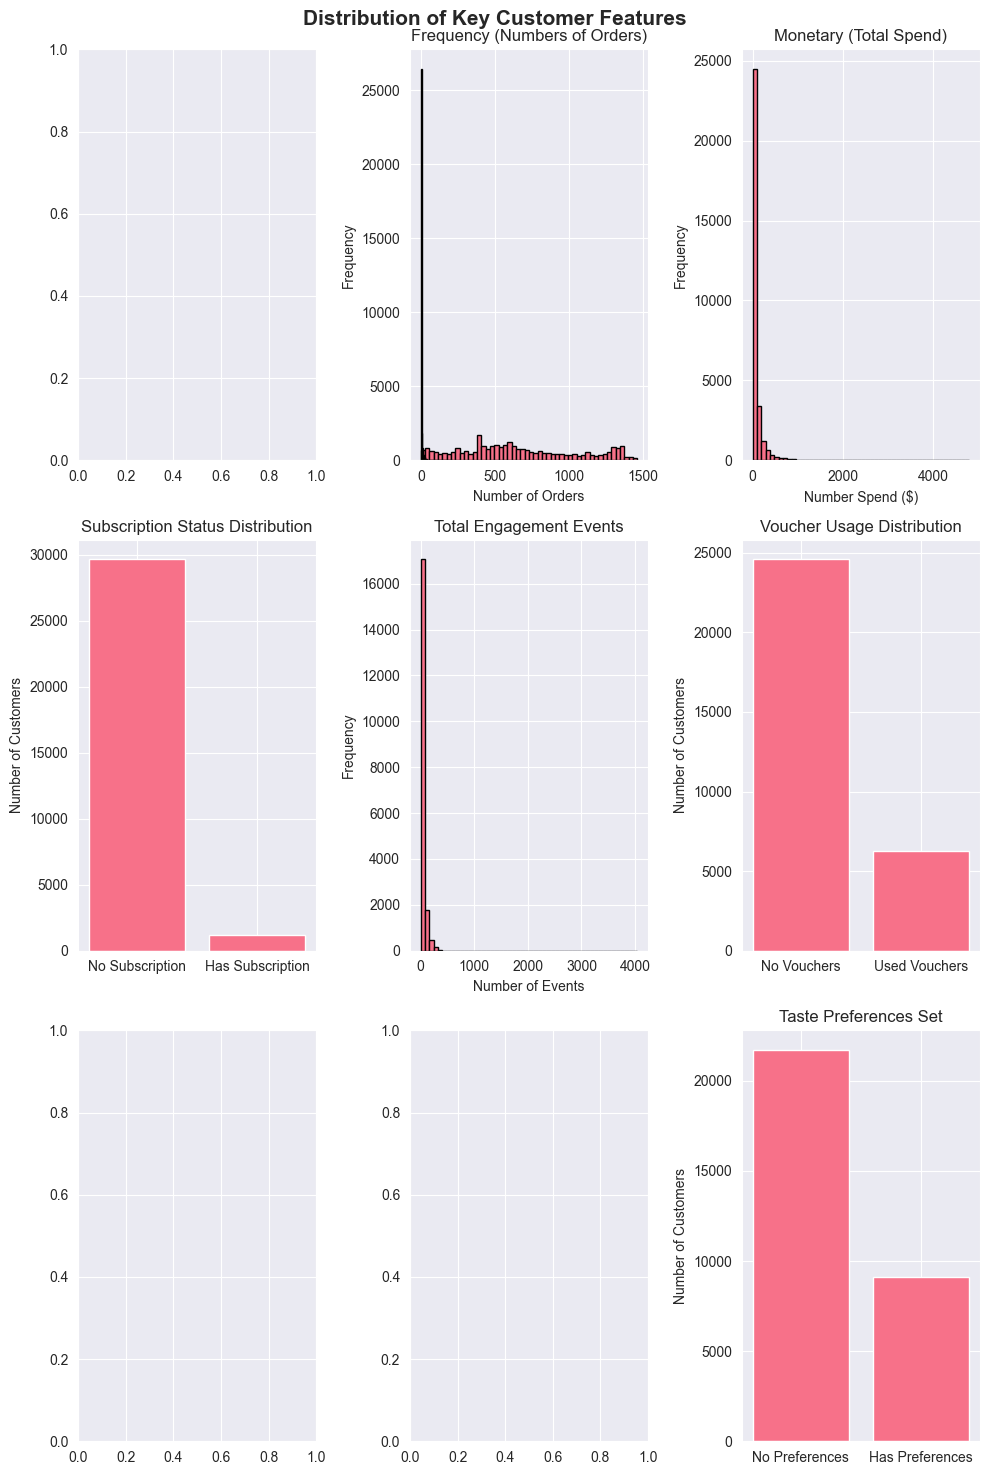

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(10, 15))
fig.suptitle("Distribution of Key Customer Features", fontsize=15, fontweight="bold")

# Recency
axes[0, 1].hist(customer_features["recency_days"], bins=50, edgecolor="black")
axes[0, 1].set_title("Recency (Days since last order)")
axes[0, 1].set_xlabel("Days")
axes[0, 1].set_ylabel("Frequency")

# Frequency
axes[0, 1].hist(customer_features["frequency_orders"], bins=50, edgecolor="black")
axes[0, 1].set_title("Frequency (Numbers of Orders)")
axes[0, 1].set_xlabel("Number of Orders")
axes[0, 1].set_ylabel("Frequency")

# Monetary
axes[0, 2].hist(customer_features["monetary_total"], bins=50, edgecolor="black")
axes[0, 2].set_title("Monetary (Total Spend)")
axes[0, 2].set_xlabel("Number Spend ($)")
axes[0, 2].set_ylabel("Frequency")

# Subscription status
# subscription_counts = customer_features["has_subscription"].value_counts()
customer_features["has_subscription"] = (customer_features["active_subscriptions"].fillna(0) > 0).astype(int)
subscription_counts = customer_features["has_subscription"].value_counts()
axes[1, 0].bar(["No Subscription", "Has Subscription"], subscription_counts.values)
axes[1, 0].set_title("Subscription Status Distribution")
axes[1, 0].set_ylabel("Number of Customers")

# Engagement
axes[1, 1].hist(customer_features["total_events"], bins=50, edgecolor="black")
axes[1, 1].set_title("Total Engagement Events")
axes[1, 1].set_xlabel("Number of Events")
axes[1, 1].set_ylabel("Frequency")

# Voucher usage
#voucher_counts = (customer_features["is_voucher_user"] > 0).value_counts()
voucher_counts = (customer_features["voucher_orders_count"].fillna(0) > 0).value_counts()
axes[1, 2].bar(["No Vouchers", "Used Vouchers"], voucher_counts.values)
axes[1, 2].set_title("Voucher Usage Distribution")
axes[1, 2].set_ylabel("Number of Customers")

# Taste Preferences,   这个地方我改了，注意  注意  注意
customer_features['has_preferences'] = customer_features['user_id'].isin(preferences_clean_df['user_id']).astype(int)
taste_counts = (customer_features["has_preferences"] >0).value_counts()
axes[2, 2].bar(["No Preferences", "Has Preferences"], taste_counts.values)
axes[2, 2].set_title("Taste Preferences Set")
axes[2, 2].set_ylabel("Number of Customers")

plt.tight_layout()
plt.show()

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x00000227B7861160>
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=bold:stretch=normal:size=14.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='d:\\Anaconda\\envs\\genAI\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='d:\\Anaconda\\envs\\genAI\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='d:\\Anaconda\\envs\\genAI\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', 

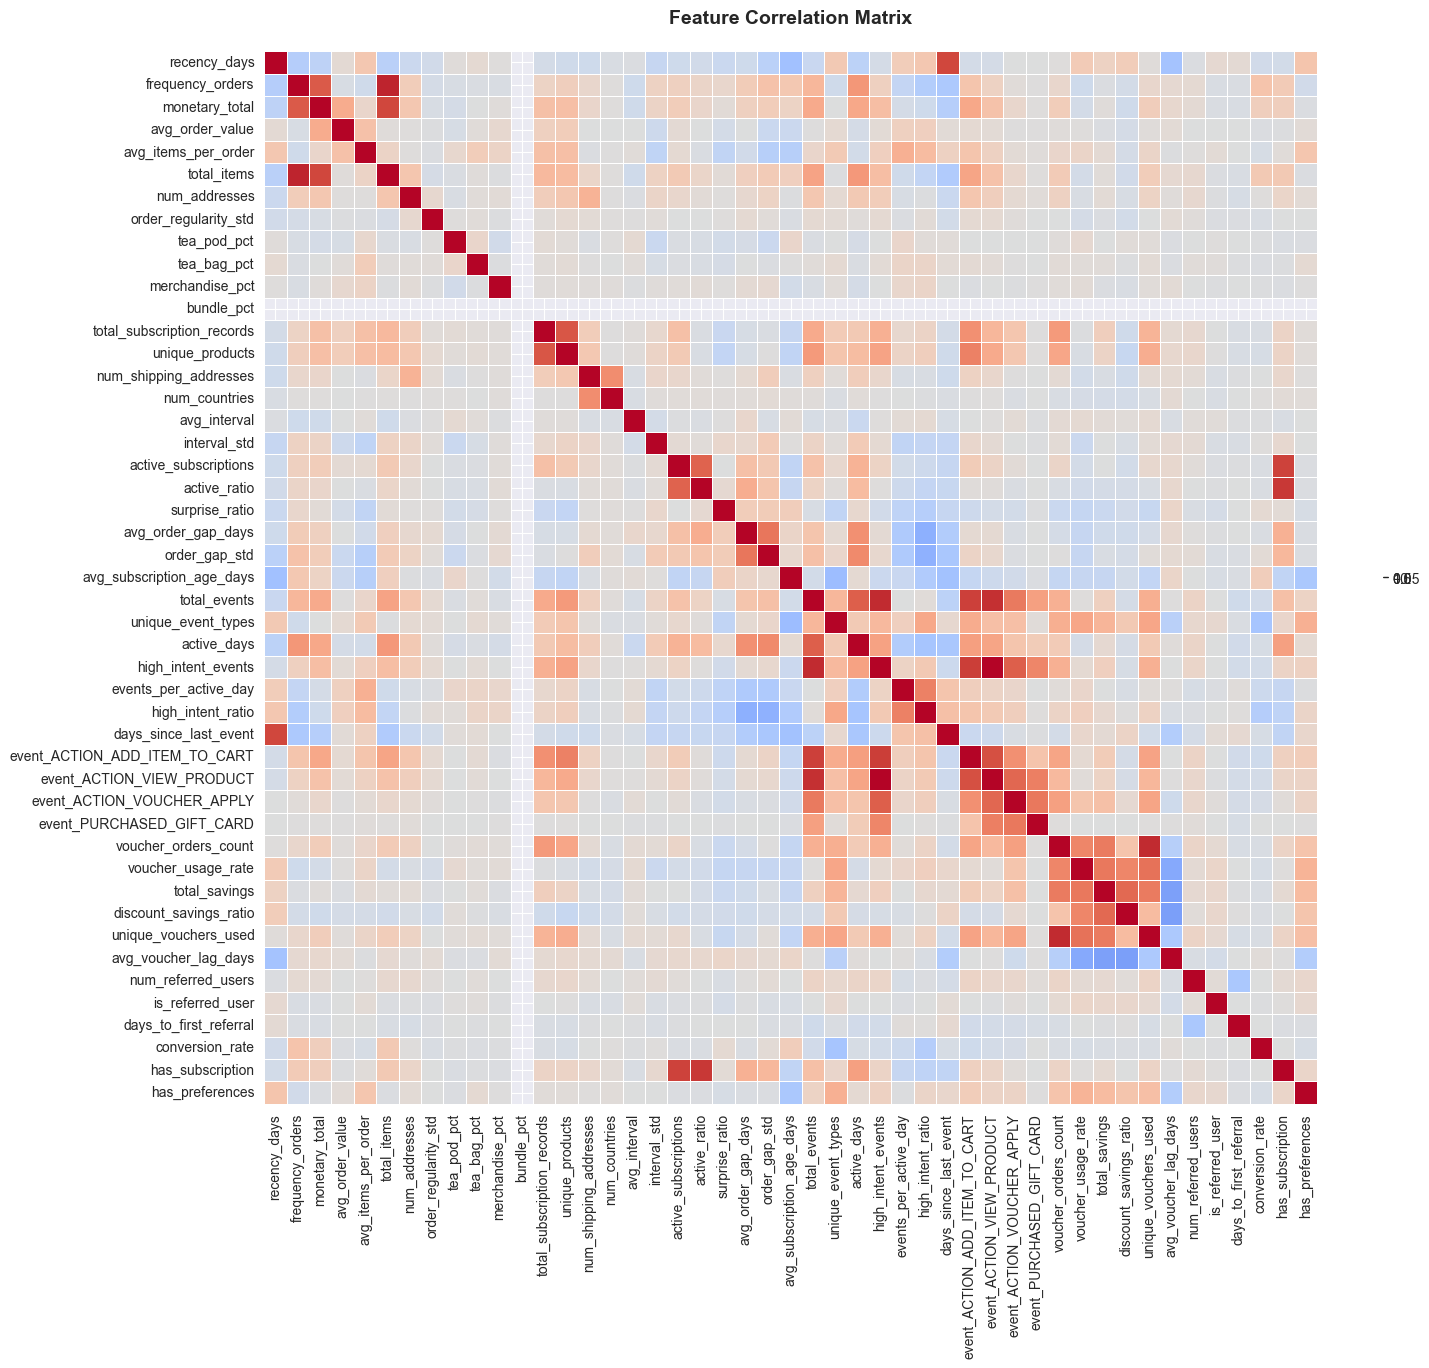

In [ ]:
plt.figure(figsize=(16, 14))

#这里新加了selct_dtypes去取数值类型，因为只能计算数值类型的相关性

numeric_features = customer_features.select_dtypes(include=[np.number]).drop("user_id", axis=1, errors="ignore")

correlation_matrix = numeric_features.corr()
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm", center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.0})
plt.title("Feature Correlation Matrix", fontsize=14, fontweight="bold", pad=20)
plt.tight_layout()
plt.show()

## K-Means Clustering

In [ ]:
clustering_features = customer_features.drop(["user_id", "primary_currency"], axis=1, errors="ignore")

logging.debug(f"Features for clustering: {len(clustering_features.columns)} features")
logging.debug(f"Shape: {clustering_features.shape}")

missing_count = clustering_features.isnull().sum().sum()
logging.debug(f"Missing values: {missing_count}")

if missing_count > 0:
    logging.warning("Found missing values")
    # 这里我也改了，非数据和数据类型不同的处理方式  注意 注意  注意
    # 只对数值型列填充中位数
    num_cols = clustering_features.select_dtypes(include=[np.number]).columns
    cluster_features = clustering_features.copy()
    cluster_features[num_cols] = cluster_features[num_cols].fillna(cluster_features[num_cols].median())
    # 对非数值型列用众数填充
    non_num_cols = clustering_features.select_dtypes(exclude=[np.number]).columns
    for col in non_num_cols:
        mode_val = clustering_features[col].mode()
        if not mode_val.empty:
            cluster_features[col] = cluster_features[col].fillna(mode_val[0])
        else:
            cluster_features[col] = cluster_features[col].fillna("unknown")
    logging.warning("Missing values filled with median/mode")
else:
    cluster_features = clustering_features.copy()

DEBUG:root:Features for clustering: 54 features
DEBUG:root:Shape: (30835, 54)
DEBUG:root:Missing values: 487187


In [ ]:

#注意这里只能是数据类型  所以又改了  注意  注意  注意
numeric_cluster_features = cluster_features.select_dtypes(include=[np.number])
scaler = StandardScaler()
features_scaled = scaler.fit_transform(numeric_cluster_features)

logging.debug("Clutering Features scaled using StandardScaler")
logging.debug(f"Scaled features shape: {features_scaled.shape}")
logging.debug(f"Scaled features mean: {features_scaled.mean():.4f}") # Should be near 0
logging.debug(f"Scaled features std: {features_scaled.std():.4f}") # Should be near 1

DEBUG:root:Clutering Features scaled using StandardScaler
DEBUG:root:Scaled features shape: (30835, 47)
DEBUG:root:Scaled features mean: -0.0000
DEBUG:root:Scaled features std: 0.9893


### Testing Different Approaches

DEBUG:root:Testing k=2
INFO:root:K=2 | Inertia=1272074.555 | Silhouette: 0.506
DEBUG:root:Testing k=3
INFO:root:K=3 | Inertia=1177984.071 | Silhouette: 0.330
DEBUG:root:Testing k=4
INFO:root:K=4 | Inertia=1118124.091 | Silhouette: 0.329
DEBUG:root:Testing k=5
INFO:root:K=5 | Inertia=1060415.794 | Silhouette: 0.228
DEBUG:root:Testing k=6
INFO:root:K=6 | Inertia=999620.108 | Silhouette: 0.295
DEBUG:root:Testing k=7
INFO:root:K=7 | Inertia=972004.307 | Silhouette: 0.300
DEBUG:root:Testing k=8
INFO:root:K=8 | Inertia=924077.689 | Silhouette: 0.253
DEBUG:root:Testing k=9
INFO:root:K=9 | Inertia=905618.933 | Silhouette: 0.217
DEBUG:root:Testing k=10
INFO:root:K=10 | Inertia=879830.066 | Silhouette: 0.218
C:\Users\user\AppData\Local\Temp\ipykernel_18552\1294363792.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


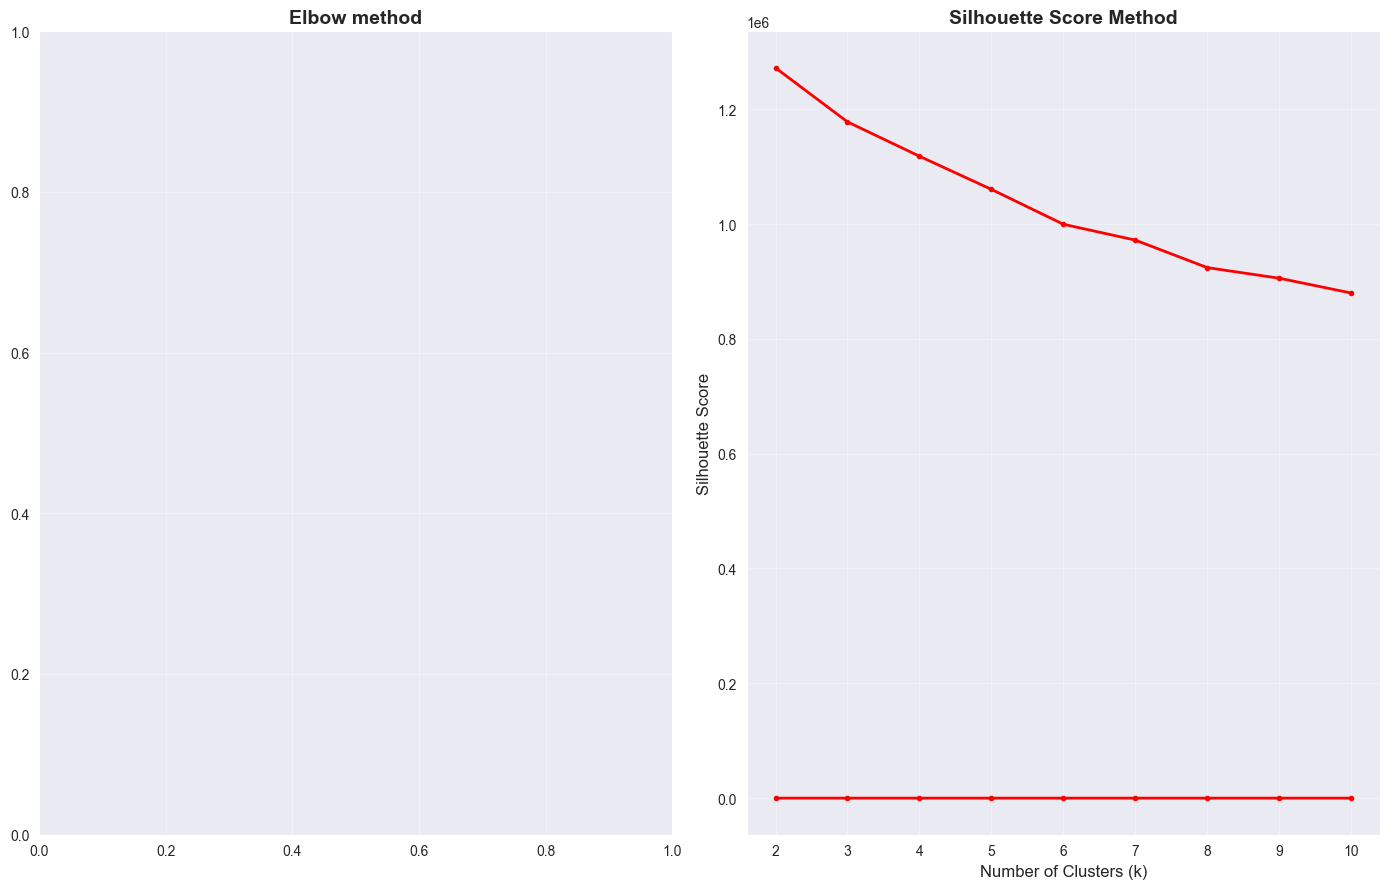

In [43]:
random_state = 1
inertias = []
silhouette_scores_list = []
k_range = range(2, 11)

for k in k_range:
    logging.debug(f"Testing k={k}")

    k_means = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    k_means.fit(features_scaled)

    inertias.append(k_means.inertia_)
    silhouette_scores_list.append(silhouette_score(features_scaled, k_means.labels_))

    logging.info(f"K={k} | Inertia={inertias[-1]:.3f} | Silhouette: {silhouette_scores_list[-1]:.3f}")


plt, axes = plt.subplots(1, 2, figsize=(14, 9))

axes[1].plot(k_range, inertias, "ro-", linewidth=2, markersize=3)
axes[1].set_xlabel("Number of Clusters (k)", fontsize=12)
axes[1].set_ylabel("Inertia (Within-cluster sum of squares)", fontsize=12)
axes[0].set_title("Elbow method", fontsize=14, fontweight="bold")
axes[0].grid(True, alpha=0.3)

axes[1].plot(k_range, silhouette_scores_list, "ro-", linewidth=2, markersize=3)
axes[1].set_xlabel("Number of Clusters (k)", fontsize=12)
axes[1].set_ylabel("Silhouette Score", fontsize=12)
axes[1].set_title("Silhouette Score Method", fontsize=14, fontweight="bold")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [45]:
optimal_k = 4

logging.debug(f"Fitting K-Means with k={optimal_k}")

k_means_final = KMeans(n_clusters=optimal_k, random_state=random_state, n_init=10)
cluster_labels = k_means_final.fit_predict(features_scaled)

customer_features["cluster"] = cluster_labels

logging.info(f"Final inertia: {k_means_final.inertia_:.2f}")
logging.info(f"Silhouette Score: {silhouette_score(features_scaled, cluster_labels):.3f}")

cluster_counts = customer_features["cluster"].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(customer_features)) * 100
    logging.info(f"Cluster {cluster_id}: {count} customers ({percentage:.1f}%)")

DEBUG:root:Fitting K-Means with k=4
INFO:root:Final inertia: 1118124.09
INFO:root:Silhouette Score: 0.329
INFO:root:Cluster 0: 1312 customers (4.3%)
INFO:root:Cluster 1: 4264 customers (13.8%)
INFO:root:Cluster 2: 24221 customers (78.6%)
INFO:root:Cluster 3: 1038 customers (3.4%)


## Cluster Analysis and Profiling
- 视频有点难看，代码很多，我懒得再抄了
- 而且我们模型不会一样
- 可以自己研究一下

In [47]:
# 要先做好一个cluster_profiles
# 让后这个是McKinsey他们的定义，只是参考

def interpret_cluster(cluster_id, profile):
    row = profile.loc[cluster_id]

    high_freq = row["frequency_orders"] > cluster_profiles["frequency_orders"].median()
    high_monetary = row["monetary_total"] > cluster_profiles["monetary_total"].median()
    low_recency = row["recency_days"] < cluster_profile["recency_days"].median()
    has_sub = row["has_subsciption"] > 0.5
    high_engagement = row["total_events"] > cluster_profiles["total_events"].median()

    if high_freq and high_monetary and has_sub:
        name = "VIP Champions"
        description = "High value loyal customers with active subscriptions"
    elif high_freq and low_recency:
        name = "Loyal Regulars"
        description = "Frequent buyers who purchase regularly"
    elif not low_recency and not high_freq:
        name = "At-Risk / Hibernating"
        description = "Previously active but haven't purchased recently"
    else:
        name = "Casual Explorers"
        description = "Infrequent buyers, potential growth"
    return name, description

for cluster_id in range(optimal_k):
    name, description = interpret_cluster(cluster_id, cluster_profiles)
    cluster_names[cluster_id] = name
    cluster_descriptions[cluster_id] = description

    size = (customer_features["cluster"] == cluster_id).sum()
    percentage = (size / len(customer_features)) * 100

    revenue_info = revenue_analysis(revenue_analysis["cluster"] == cluster_id).iloc[0]
    logging.info(f"Cluster {cluster_id}: {name}")
    logging.info(f"Description: {description}")
    logging.info(f"Size: {size} customers ({percentage:.1f}%)")
    # logging.info(f"Revenue contribution: {revenue_info["total_revenue"]:.2f} ({revenue_info["total_pct"]:.2f}% of total)")


    row = cluster_profiles.loc[cluster_id]
    # log out avg recency, avg frequency, avg total spend, avg order value
    # subscription rate, avg engagement events, voucher usage rate
    # referral rate



NameError: name 'cluster_profiles' is not defined

## Business Recommendations

In [48]:
recommendations = []

for _, rev_row in revenue_analysis.iterrows():
    cluster_id = int(rev_row["cluster"])
    row = cluster_profiles.loc[cluster_id]
    name = cluster_names[cluster_id]
    descriptions = cluster_descriptions[cluster_id]
    size = int(rev_row["customer_count"])

    strategies = []

    if row["monetary_total"] > cluster_profiles["monetary_total"].quantile(0.75):
        strategies.append("VIP program: Exclusive early access to new products")
        strategies.append("Premium Offerings: Introduce limited edition or premium...")
    # something like this...


# Also find the priority of each cluster and show why(size%, revenue contribution, avg revenue per customer)
# sort by this priority

NameError: name 'revenue_analysis' is not defined